In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In this notebook I relate the brexit voting data per area to various demographic data found at [2011 Census, Key Statistics for Local Authorities in England and Wales](http://webarchive.nationalarchives.gov.uk/20160105160709/http://www.ons.gov.uk/ons/publications/re-reference-tables.html?edition=tcm%3A77-286262). I check if there is a relation between the voting and median age, unemployment, higher education and born outside UK.

Define the census tables we need:

In [142]:
census_data = {
     "age" : "http://webarchive.nationalarchives.gov.uk/20160105160709/http://www.ons.gov.uk/ons/rel/census/2011-census/key-statistics-for-local-authorities-in-england-and-wales/rft-table-ks102ew.xls",
     "unemployment" : "http://webarchive.nationalarchives.gov.uk/20160105160709/http://www.ons.gov.uk/ons/rel/census/2011-census/key-statistics-for-local-authorities-in-england-and-wales/rft-table-ks601ew.xls",
     "education" : "http://webarchive.nationalarchives.gov.uk/20160105160709/http://www.ons.gov.uk/ons/rel/census/2011-census/key-statistics-for-local-authorities-in-england-and-wales/rft-table-ks501ew.xls",
     "outside_uk" : "http://webarchive.nationalarchives.gov.uk/20160105160709/http://www.ons.gov.uk/ons/rel/census/2011-census/key-statistics-for-local-authorities-in-england-and-wales/rft-table-qs203ew.xls",
}

Load in the votes data and calculate the diff Remain - Leave (so negative is "in favor of Leave")

In [143]:
votes_org = pd.read_csv("http://www.electoralcommission.org.uk/__data/assets/file/0014/212135/EU-referendum-result-data.csv", usecols=["Area_Code", "Region", "Remain", "Leave"] )
votes_org.rename(index=str, inplace=True, columns={"Area_Code": "Area code", }) # same col name for merge
votes_org["votes"] = votes_org["Remain"] - votes_org["Leave"]
votes = votes_org[["Area code", "votes"]]

In [144]:
votes.head(2)

,Area code,votes
0,E06000031,-19040
1,E06000032,-11065


Load in the census data one by one:

In [145]:
age = pd.read_excel(io=census_data["age"], sheetname="KS102EW_Numbers", header=10, parse_cols=("A,W"), skiprows=[11,12,13])
age.dropna(how='all', inplace=True)
age.rename(index=str, inplace=True, columns={"Median age": "median_age", }) 
age = age[["Area code", "median_age"]]
age.head(2)

,Area code,median_age
0,K04000001,39.0
2,E92000001,39.0


In [146]:
unemployment = pd.read_excel(io=census_data["unemployment"], sheetname="KS601EW_Numbers", header=10, parse_cols=("A,E,I"), skiprows=[11,12,13])
unemployment.dropna(how='all', inplace=True)
unemployment["perc_unemployed"] = unemployment[unemployment.columns[2]] / unemployment[unemployment.columns[1]]
unemployment = unemployment[["Area code", "perc_unemployed"]]
unemployment.head(2)

,Area code,perc_unemployed
0,K04000001,0.043756
2,E92000001,0.043796


In [147]:
# level 3 and 4+ = cols J and K 
education = pd.read_excel(io=census_data["education"], sheetname="KS501EW_Numbers", header=10, parse_cols=("A,E,J,K"), skiprows=[11,12,13])
education.dropna(how='all', inplace=True)
education["perc_high_education"] = (education[education.columns[2]] + education[education.columns[3]]) / education[education.columns[1]]
education = education[["Area code", "perc_high_education"]]
education.head(2)

,Area code,perc_high_education
1,K04000001,0.395661
3,E92000001,0.397282


In [148]:
outside_uk = pd.read_excel(io=census_data["outside_uk"], sheetname="QS203EW_Numbers", header=10, parse_cols=("A,E,G"), skiprows=[11,12,13])
outside_uk.dropna(how='all', inplace=True)
outside_uk.columns[2]
# all birth (col E) - UK birth (col G) = outside birth
outside_uk["perc_born_outside_uk"] = (outside_uk[outside_uk.columns[1]] - outside_uk[outside_uk.columns[2]]) / outside_uk[outside_uk.columns[1]]
outside_uk = outside_uk[["Area code", "perc_born_outside_uk"]]
outside_uk.head(2)

,Area code,perc_born_outside_uk
0,K04000001,0.133837
2,E92000001,0.138404


Merge all datasets to one dataframe, on key = Area code

In [149]:
data = votes.merge(age, on='Area code').merge(unemployment, on='Area code').merge(education, on='Area code').merge(outside_uk, on='Area code')
data.head(5)

,Area code,votes,median_age,perc_unemployed,perc_high_education,perc_born_outside_uk
0,E06000031,-19040,35.0,0.050568,0.310281,0.206349
1,E06000032,-11065,32.0,0.057414,0.333318,0.309408
2,E06000033,-15174,40.0,0.049669,0.332425,0.098596
3,E06000034,-35614,36.0,0.054239,0.283631,0.119692
4,E06000055,-3072,39.0,0.044478,0.399608,0.176049


Important note, not all area codes of the votes csv data were in the census data, but I was able to match 89,5%, not too bad:

In [150]:
100 - ((len(votes) - len(data)) / len(votes)*100)


89.52879581151832

Use scatter plots to show the relations. Defining a function to avoid too much repetition of code:

In [151]:
def showplot(data, factor):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1,1,1) 
    ax.scatter(data["votes"], data[factor], s=20, c='r', marker="o", label=factor)
    plt.legend(loc='upper left');
    plt.xlabel("votes (< 0 = leave / > 0 = remain)")
    plt.ylabel(factor)
    plt.axvline(x=0)
    plt.axhline(y=data[factor].mean()) # draw a horizontal line in the mean of the dataset
    plt.show()
    #fig.savefig(factor+".png")

### 1. Age

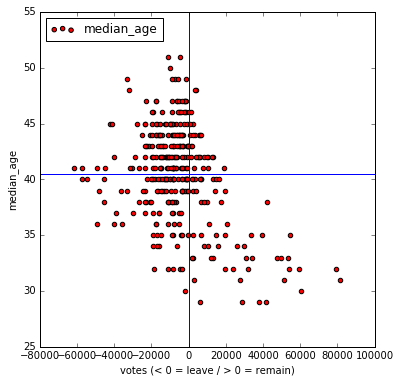

In [152]:
showplot(data, "median_age")

It seems more older people want to leave the EU

### 2. Unemployment

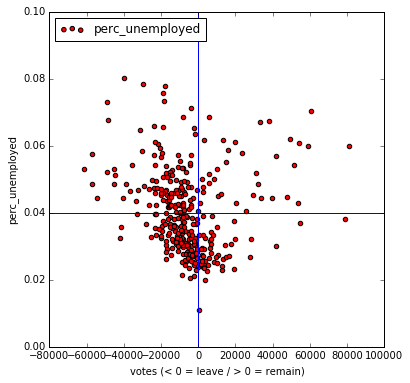

In [153]:
showplot(data, "perc_unemployed")

The higher the unemployment rate, the higher the desire to leave.

### 3. Higher education

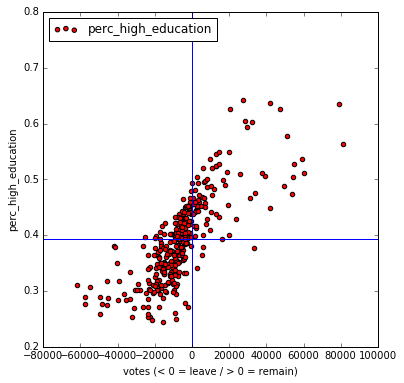

In [154]:
showplot(data, "perc_high_education")

Areas with a higher percentage of education tend to be in favor of remain.

### 4. Born outside UK

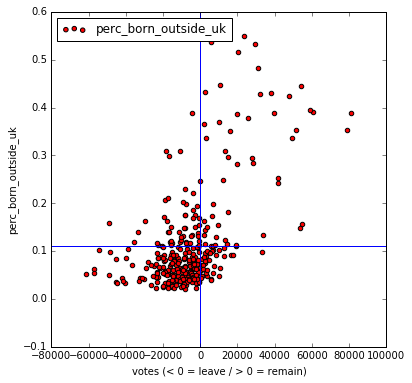

In [155]:
showplot(data, "perc_born_outside_uk")

Here we see that the greater % of an area born outside UK is more in favor of remain

## 5. Income

Last but not least I wanted to find out how the income level influenced the voting. I found [this source](https://www.gov.uk/government/statistics/income-and-tax-by-county-and-region-2010-to-2011) but it is per region (not area) so I had to group the voting data by region as well:

In [175]:
votes_region = votes_org.groupby("Region").sum()
votes_region.head(2)

,Remain,Leave,votes
Region,,,
East,1448616,1880367,-431751
East Midlands,1033036,1475479,-442443


In [176]:
len(votes_region)

12

In [177]:
# get the median income per area / region (they are in the same column but merge later will fix that)
income_url = "https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/510864/Table_3_13_14.xlsx"
income = pd.read_excel(io=income_url, sheetname="Table_3_13_14", header=10, parse_cols=("A,U"), skiprows=[11,12,13], )
income.dropna(how='all', inplace=True)
income.rename(index=str, columns={income.columns[0]: "Region", income.columns[1]: "median_income"}, inplace=True)
income.set_index("Region", inplace=True)
income.head(5)

,median_income
Region,
England,22100.0
North East,20400.0
Tyne & Wear,20400.0
Unitary Authorities,20400.0
North West,20600.0


In [178]:
votes_region.index

Index(['East', 'East Midlands', 'London', 'North East', 'North West',
       'Northern Ireland', 'Scotland', 'South East', 'South West', 'Wales',
       'West Midlands', 'Yorkshire and The Humber'],
      dtype='object', name='Region')

In [179]:
# income data has whitespace so merge did not match, clean the whitespaces
income.index = income.index.str.strip()

In [180]:
# we miss 2 regions, accepting that for now (want to get a 'rough' indication)
[i for i in votes_region.index if i not in income.index]

['East', 'Yorkshire and The Humber']

In [181]:
# merge the votes and income data sets on their region indexes
votes_and_income = votes_region.merge(income, left_index=True, right_index=True, how='left')
votes_and_income.drop_duplicates(subset="Remain", keep="first", inplace=True)
votes_and_income = votes_and_income[votes_and_income["median_income"] > 0] # clean 2 NANs
votes_and_income

,Remain,Leave,votes,median_income
Region,,,,
East Midlands,1033036,1475479,-442443,20800.0
London,2263519,1513232,750287,25600.0
North East,562595,778103,-215508,20400.0
North West,1699020,1966925,-267905,20600.0
Northern Ireland,440707,349442,91265,20100.0
Scotland,1661191,1018322,642869,21800.0
South East,2391718,2567965,-176247,23900.0
South West,1503019,1669711,-166692,21200.0
Wales,772347,854572,-82225,20300.0


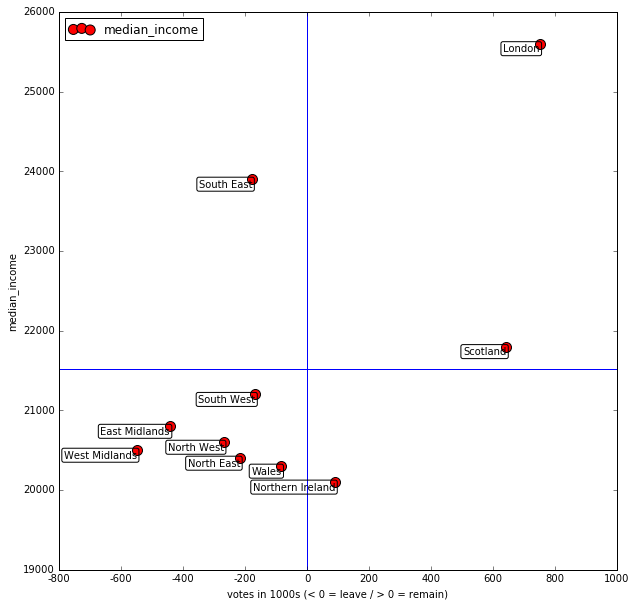

In [189]:
# cannot reuse earlier showplot method, so tweak the code here
# had to add FuncFormatter as well because the x axis has much greater vote values, because we measure 
# regions (=bigger) instead of areas (=smaller) here
factor = "median_income"
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1) 
ax.scatter(votes_and_income["votes"], votes_and_income[factor], s=100, c='r', marker="o", label=factor)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: ('%2d')%(y*1e-3)))
# show region name for each dot
for i, txt in enumerate(votes_and_income.index):
    ax.annotate(txt, (votes_and_income["votes"][i], votes_and_income[factor][i]), 
               horizontalalignment='right', verticalalignment='top',
               bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(loc='upper left');
plt.xlabel("votes in 1000s (< 0 = leave / > 0 = remain)")
plt.ylabel(factor)
plt.axvline(x=0)

plt.axhline(y=votes_and_income[factor].mean()) # draw a horizontal line in the mean of the dataset
plt.show()
#fig.savefig(factor+".png")

Conclusion: we clearly see that regions with a relatively smaller median income are more in favor of leaving the EU, although it is not 100% consistent: Scotland has a lower median income but voted Remain, South East has a higher median income but wants to leave. Interesting though how general trends become visible by merging different data sets.